In [1]:
import numpy as np # 행렬 연산 / 데이터 핸들링
import pandas as pd # 데이터 분석
import matplotlib.pyplot as plt # 그래프 시각화
import seaborn as sns # 그래프 시각화
# from xgboost import XGBRegressor # XGBoost Regressor 모델
from sklearn.model_selection import KFold # K-validation
from sklearn.metrics import accuracy_score # 정확도 측정 함수
from sklearn.preprocessing import LabelEncoder # 라벨 인코더

## 1. 프로젝트 목적

버스 운행 시간 예측 모델 개발

제주도내 주민등록인구는 2019년 11월 기준 69만명으로, 연평균 4%대로 성장

외국인과 관광객까지 고려하면 전체 상주인구는 90만명을 넘을 것으로 추정

제주도민 증가와 외국인의 증가로 현재 제주도의 교통체증이 심각한 문제

제주도 버스의 효율적인 운행을 위해 운행 시간을 예측하는 모델 개발

### 1-1. 수행 목적

버스 운행 시간에 영향을 미치는 다른 변수(날씨 등)를 외부데이터로 삽입하여

날씨 / 기후에 따른 운행 시간 예측 검증을 추가

## 2. 조별 역할

데이터 분석, 전처리, 모델 학습 및 검증 공동 

## 3. 데이터 설명

해당 날짜 별, 노선 및 버스 ID가 주어진 상황에서 현재 정류소의 이름과 현재 정류장 도착 시간을 이용하여,

다음 정류장에 도착할 때까지 걸리는 시간을 예측하기 위한 데이터

#### 1) 학습/테스트데이터


In [2]:
bus_te = pd.read_csv('test.csv', sep=',')
bus_tr = pd.read_csv('train.csv', sep=',')
bus_tr.head()

,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time
0,0,2019-10-15,405136001,7997025,360-1,33.456267,126.551750,제주대학교입구,06시,266.0,제대마을,33.457724,126.554014,24
1,1,2019-10-15,405136001,7997025,360-1,33.457724,126.554014,제대마을,06시,333.0,제대아파트,33.458783,126.557353,36
2,2,2019-10-15,405136001,7997025,360-1,33.458783,126.557353,제대아파트,06시,415.0,제주대학교,33.459893,126.561624,40
3,3,2019-10-15,405136001,7997025,360-1,33.479705,126.543811,남국원(아라방면),06시,578.0,제주여자중고등학교(아라방면),33.484860,126.542928,42
4,4,2019-10-15,405136001,7997025,360-1,33.485662,126.494923,도호동,07시,374.0,은남동,33.485822,126.490897,64


In [3]:
bus_te.head()

,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude
0,210457,2019-10-29,405136001,7997025,360-1,33.457724,126.554014,제대마을,07시,333.0,제대아파트,33.458783,126.557353
1,210458,2019-10-29,405136001,7997025,360-1,33.458783,126.557353,제대아파트,07시,415.0,제주대학교,33.459893,126.561624
2,210459,2019-10-29,405136001,7997025,360-1,33.478867,126.483833,한라중학교/부영아파트,08시,417.0,대림2차아파트,33.478850,126.488350
3,210460,2019-10-29,405136001,7997025,360-1,33.478850,126.488350,대림2차아파트,08시,334.0,연동대림1차아파트,33.480700,126.489933
4,210461,2019-10-29,405136001,7997025,360-1,33.480700,126.489933,연동대림1차아파트,08시,550.0,케이티앤지,33.482077,126.485355


- ① id: 해당 데이터에서의 고유한 ID
- ② date: 버스 운행 날짜
- ③ route_id: 버스 노선 ID
- ④ vh_id: 버스 ID
- ⑤ route_nm: 버스 노선 실제 번호
- ⑥ now_latitude: 현재 정류소의 위도
- ⑦ now_longitude: 현재 정류소의 경도
- ⑧ now_station: 현재 정류소 이름
- ⑨ now_arrive_time: 현재 정류장에 도착한 시간
- ⑩ distance: 현재 정류장에서 다음 정류장까지 실제 이동한 거리
- ⑪ next_station: 다음 정류소 이름
- ⑫ next_latitude: 다음 정류소의 위도
- ⑬ next_longitude: 다음 정류소의 경도
- ⑭ next_arrive_time: 다음 정류장에 도착할 때 까지 걸린 시간(단위:초)으로 답안 제출을 위해서 예측해야 되는 값 (train 데이터에만)

In [5]:
bus_tr.shape, bus_te.shape

((210457, 14), (91774, 13))

In [7]:
bus_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210457 entries, 0 to 210456
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                210457 non-null  int64  
 1   date              210457 non-null  object 
 2   route_id          210457 non-null  int64  
 3   vh_id             210457 non-null  int64  
 4   route_nm          210457 non-null  object 
 5   now_latitude      210457 non-null  float64
 6   now_longitude     210457 non-null  float64
 7   now_station       210457 non-null  object 
 8   now_arrive_time   210457 non-null  object 
 9   distance          210457 non-null  float64
 10  next_station      210457 non-null  object 
 11  next_latitude     210457 non-null  float64
 12  next_longitude    210457 non-null  float64
 13  next_arrive_time  210457 non-null  int64  
dtypes: float64(5), int64(4), object(5)
memory usage: 22.5+ MB


In [8]:
bus_tr.isna().sum()

id                  0
date                0
route_id            0
vh_id               0
route_nm            0
now_latitude        0
now_longitude       0
now_station         0
now_arrive_time     0
distance            0
next_station        0
next_latitude       0
next_longitude      0
next_arrive_time    0
dtype: int64

In [9]:
bus_te.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91774 entries, 0 to 91773
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               91774 non-null  int64  
 1   date             91774 non-null  object 
 2   route_id         91774 non-null  int64  
 3   vh_id            91774 non-null  int64  
 4   route_nm         91774 non-null  object 
 5   now_latitude     91774 non-null  float64
 6   now_longitude    91774 non-null  float64
 7   now_station      91774 non-null  object 
 8   now_arrive_time  91774 non-null  object 
 9   distance         91774 non-null  float64
 10  next_station     91774 non-null  object 
 11  next_latitude    91774 non-null  float64
 12  next_longitude   91774 non-null  float64
dtypes: float64(5), int64(3), object(5)
memory usage: 9.1+ MB


In [10]:
bus_te.isna().sum()

id                 0
date               0
route_id           0
vh_id              0
route_nm           0
now_latitude       0
now_longitude      0
now_station        0
now_arrive_time    0
distance           0
next_station       0
next_latitude      0
next_longitude     0
dtype: int64

In [11]:
bus_tr['next_arrive_time'].describe

<bound method NDFrame.describe of 0         24
1         36
2         40
3         42
4         64
          ..
210452    96
210453    50
210454    16
210455    38
210456    24
Name: next_arrive_time, Length: 210457, dtype: int64>

#### 2) 데이터 전처리

- 이상치 제거 하지말자! 
- 최고의 distance 값에 해당하는 target이 600대라서 700에서 적당히 끊었다~ 라는 말이 무슨 말인지 모르겠다.


In [12]:
bus_tr['next_arrive_time'].describe()

count    210457.000000
mean         85.380824
std          85.051170
min           6.000000
25%          44.000000
50%          66.000000
75%         102.000000
max        2996.000000
Name: next_arrive_time, dtype: float64

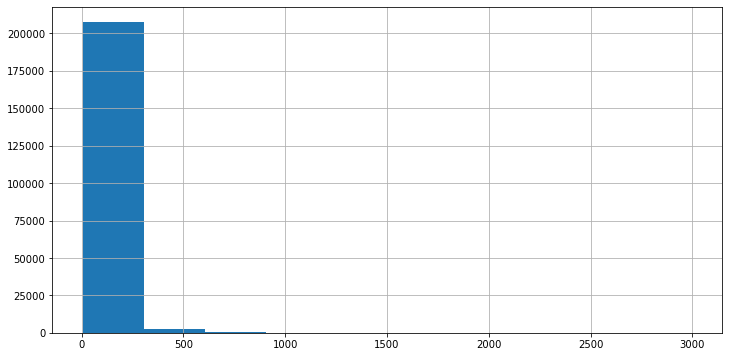

In [13]:
target = bus_tr['next_arrive_time']

plt.figure(figsize=(12,6))
plt.hist(target)
plt.grid(True)
plt.show()

In [14]:
bus_tr = bus_tr[bus_tr['next_arrive_time'] <= 700]  # 과제 : 정확한 이상치 제거 기준 찾기 
bus_tr.head()

,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time
0,0,2019-10-15,405136001,7997025,360-1,33.456267,126.551750,제주대학교입구,06시,266.0,제대마을,33.457724,126.554014,24
1,1,2019-10-15,405136001,7997025,360-1,33.457724,126.554014,제대마을,06시,333.0,제대아파트,33.458783,126.557353,36
2,2,2019-10-15,405136001,7997025,360-1,33.458783,126.557353,제대아파트,06시,415.0,제주대학교,33.459893,126.561624,40
3,3,2019-10-15,405136001,7997025,360-1,33.479705,126.543811,남국원(아라방면),06시,578.0,제주여자중고등학교(아라방면),33.484860,126.542928,42
4,4,2019-10-15,405136001,7997025,360-1,33.485662,126.494923,도호동,07시,374.0,은남동,33.485822,126.490897,64


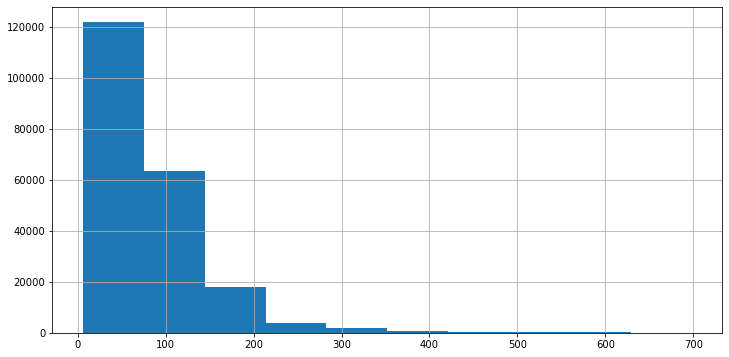

In [15]:
target = bus_tr['next_arrive_time']

plt.figure(figsize=(12,6))
plt.hist(target)
plt.grid(True)
plt.show()

- 정류장명 인코딩

In [15]:
station = list(bus_tr['now_station'].values) + list(bus_tr['next_station'].values) # train_data 의 모든 정류장 이름
station_set = set(station)
print(len(station_set))

351


In [16]:
station_encoder = LabelEncoder()        # 인코더 생성
station_encoder.fit(list(station_set))  # 인코딩 

# train 정류장 치환
bus_tr['now_station'] = station_encoder.transform(bus_tr['now_station'])
bus_tr['next_station'] = station_encoder.transform(bus_tr['next_station'])

# test 정류장 치환 
bus_te['now_station'] = station_encoder.transform(bus_te['now_station'])
bus_te['next_station'] = station_encoder.transform(bus_te['next_station'])
bus_tr.head()

,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time
0,0,2019-10-15,405136001,7997025,360-1,33.456267,126.551750,239,06시,266.0,227,33.457724,126.554014,24
1,1,2019-10-15,405136001,7997025,360-1,33.457724,126.554014,227,06시,333.0,228,33.458783,126.557353,36
2,2,2019-10-15,405136001,7997025,360-1,33.458783,126.557353,228,06시,415.0,235,33.459893,126.561624,40
3,3,2019-10-15,405136001,7997025,360-1,33.479705,126.543811,41,06시,578.0,249,33.484860,126.542928,42
4,4,2019-10-15,405136001,7997025,360-1,33.485662,126.494923,63,07시,374.0,221,33.485822,126.490897,64


- 필요X feature 제거 

In [17]:
# train data

bus_tr = bus_tr.drop(['id', 'route_nm', 'next_latitude', 'next_longitude', 
                              'now_latitude', 'now_longitude'], axis=1)
bus_tr.head()

,date,route_id,vh_id,now_station,now_arrive_time,distance,next_station,next_arrive_time
0,2019-10-15,405136001,7997025,239,06시,266.0,227,24
1,2019-10-15,405136001,7997025,227,06시,333.0,228,36
2,2019-10-15,405136001,7997025,228,06시,415.0,235,40
3,2019-10-15,405136001,7997025,41,06시,578.0,249,42
4,2019-10-15,405136001,7997025,63,07시,374.0,221,64


In [18]:
# test data

bus_te = bus_te.drop(['route_nm', 'next_latitude', 'next_longitude', 
                              'now_latitude', 'now_longitude'], axis=1)
bus_te.head()

,id,date,route_id,vh_id,now_station,now_arrive_time,distance,next_station
0,210457,2019-10-29,405136001,7997025,227,07시,333.0,228
1,210458,2019-10-29,405136001,7997025,228,07시,415.0,235
2,210459,2019-10-29,405136001,7997025,323,08시,417.0,59
3,210460,2019-10-29,405136001,7997025,59,08시,334.0,183
4,210461,2019-10-29,405136001,7997025,183,08시,550.0,285


- feature 생성) 날짜 -> 요일(평일/주말)

In [19]:
# train 

bus_tr['date'] = pd.to_datetime(bus_tr['date']) # date 값을 datetime으로
bus_tr['weekday'] = bus_tr['date'].dt.weekday  # Monday 0, Sunday 6
bus_tr['weekday'] = bus_tr['weekday'].apply(lambda x: 0 if x < 5  else 1) # 0 ~ 5 평일 = 0, 주말 = 1 
# bus_tr['weekday'] = bus_tr['weekday'].apply(lambda x: 0 if x &lt; 5 else 1)
# https://coding-factory.tistory.com/396 
# 0 ~ 5 는 월요일 ~ 금요일이므로 평일이면 0, 주말이면 1을 설정하였다

bus_tr = pd.get_dummies(bus_tr, columns=['weekday']) # 평일/주말에 대해 One-hot Encoding
bus_tr.rename(columns={'weekday_0':'weekdays'}, inplace=True)
bus_tr.rename(columns={'weekday_1':'weekdends'}, inplace=True)
bus_tr = bus_tr.drop('date', axis=1) # 필요없는 date 칼럼을 drop
bus_tr.head()

,route_id,vh_id,now_station,now_arrive_time,distance,next_station,next_arrive_time,weekdays,weekdends
0,405136001,7997025,239,06시,266.0,227,24,1,0
1,405136001,7997025,227,06시,333.0,228,36,1,0
2,405136001,7997025,228,06시,415.0,235,40,1,0
3,405136001,7997025,41,06시,578.0,249,42,1,0
4,405136001,7997025,63,07시,374.0,221,64,1,0


In [20]:
# test
# 시험데이터도 마찬가지로 처리해준다.

bus_te['date'] = pd.to_datetime(bus_te['date'])
bus_te['weekday'] = bus_te['date'].dt.weekday  # Monday 0, Sunday 6
bus_te['weekday'] = bus_te['weekday'].apply(lambda x: 0 if x < 5 else 1)

bus_te = pd.get_dummies(bus_te, columns=['weekday'])
bus_te.rename(columns={'weekday_0':'weekdays'}, inplace=True)
bus_te.rename(columns={'weekday_1':'weekends'}, inplace=True)
bus_te = bus_te.drop('date', axis=1) # 필요없는 date 칼럼을 drop
bus_te.head()

,id,route_id,vh_id,now_station,now_arrive_time,distance,next_station,weekdays,weekends
0,210457,405136001,7997025,227,07시,333.0,228,1,0
1,210458,405136001,7997025,228,07시,415.0,235,1,0
2,210459,405136001,7997025,323,08시,417.0,59,1,0
3,210460,405136001,7997025,59,08시,334.0,183,1,0
4,210461,405136001,7997025,183,08시,550.0,285,1,0


- now_arrive_time -> 아침/ 오후/ 저녁

In [21]:
# 현재 도착시간 분포 보기

C:\Users\CPB06GameN\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\CPB06GameN\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0, flags=flags)


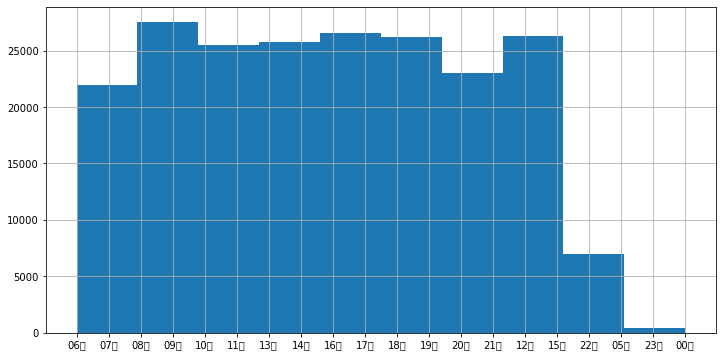

In [22]:
time = bus_tr['now_arrive_time']

plt.figure(figsize=(12,6))
plt.hist(time)
plt.grid(True)
plt.show()

In [23]:
np.sort(bus_tr['now_arrive_time'].unique())
# 01시 ~ 04시의 데이터가 존재하지 않는다 -> 새벽X 
# np 정렬
# https://rfriend.tistory.com/357

array(['00시', '05시', '06시', '07시', '08시', '09시', '10시', '11시', '12시',
       '13시', '14시', '15시', '16시', '17시', '18시', '19시', '20시', '21시',
       '22시', '23시'], dtype=object)

In [24]:
# 오전 오후 저녁 --> 과제 : 조금 더 세분화 
# 05시 ~ 11시 : 아침
# 12시 ~ 17시 : 오후 
# 18시 ~ 00시 : 저녁

# train

bus_tr['time_group']='group' #time_group 변수를 미리 생성

bus_tr.loc[ (bus_tr['now_arrive_time']>='05시') & (bus_tr['now_arrive_time']<'12시') ,['time_group'] ]= 'morning' # 05~11시
bus_tr.loc[ (bus_tr['now_arrive_time']>='12시') & (bus_tr['now_arrive_time']<'18시') ,['time_group'] ]= 'afternoon' #12~17시
bus_tr.loc[ (bus_tr['now_arrive_time']>='18시') | (bus_tr['now_arrive_time']=='00시'),['time_group'] ]= 'evening' #18~00시

bus_tr = pd.get_dummies(bus_tr,columns=['time_group']) # 원 핫 인코딩을 수행
bus_tr = bus_tr.drop('now_arrive_time', axis=1) # 필요없는 now_arrive_time drop
bus_tr.head()

,route_id,vh_id,now_station,distance,next_station,next_arrive_time,weekdays,weekdends,time_group_afternoon,time_group_evening,time_group_morning
0,405136001,7997025,239,266.0,227,24,1,0,0,0,1
1,405136001,7997025,227,333.0,228,36,1,0,0,0,1
2,405136001,7997025,228,415.0,235,40,1,0,0,0,1
3,405136001,7997025,41,578.0,249,42,1,0,0,0,1
4,405136001,7997025,63,374.0,221,64,1,0,0,0,1


In [25]:
# test data


bus_te['time_group']='group'

bus_te.loc[ (bus_te['now_arrive_time']>='05시') & (bus_te['now_arrive_time']<'12시') ,['time_group'] ]= 'morning' # 05~11시
bus_te.loc[ (bus_te['now_arrive_time']>='12시') & (bus_te['now_arrive_time']<'18시') ,['time_group'] ]= 'afternoon' #12~17시
bus_te.loc[ (bus_te['now_arrive_time']>='18시') | (bus_te['now_arrive_time']=='00시'),['time_group'] ]= 'evening' #18~00시

bus_te = pd.get_dummies(bus_te,columns=['time_group'])
bus_te = bus_te.drop('now_arrive_time', axis=1)
bus_te.head()

,id,route_id,vh_id,now_station,distance,next_station,weekdays,weekends,time_group_afternoon,time_group_evening,time_group_morning
0,210457,405136001,7997025,227,333.0,228,1,0,0,0,1
1,210458,405136001,7997025,228,415.0,235,1,0,0,0,1
2,210459,405136001,7997025,323,417.0,59,1,0,0,0,1
3,210460,405136001,7997025,59,334.0,183,1,0,0,0,1
4,210461,405136001,7997025,183,550.0,285,1,0,0,0,1


- 시각화

In [26]:
# 평일/주말
# 시간대별 
# pairplot << 잘 안되는데..
# heatmap도 해도 되나? 
# 전처리가 끝난 데이터들을 가지고, 각각의 feature 들이 target에 얼마만큼의 상관관계를 가지고 있는지 시각화를 통해 알아보겠습니다.

<AxesSubplot:>

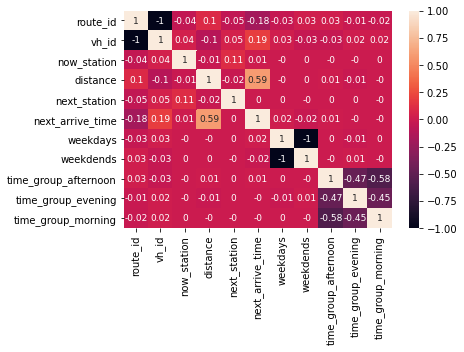

In [27]:

data = bus_tr.corr(method='pearson').round(2)
sns.heatmap(data=data, annot=True, annot_kws={"size":9}, )

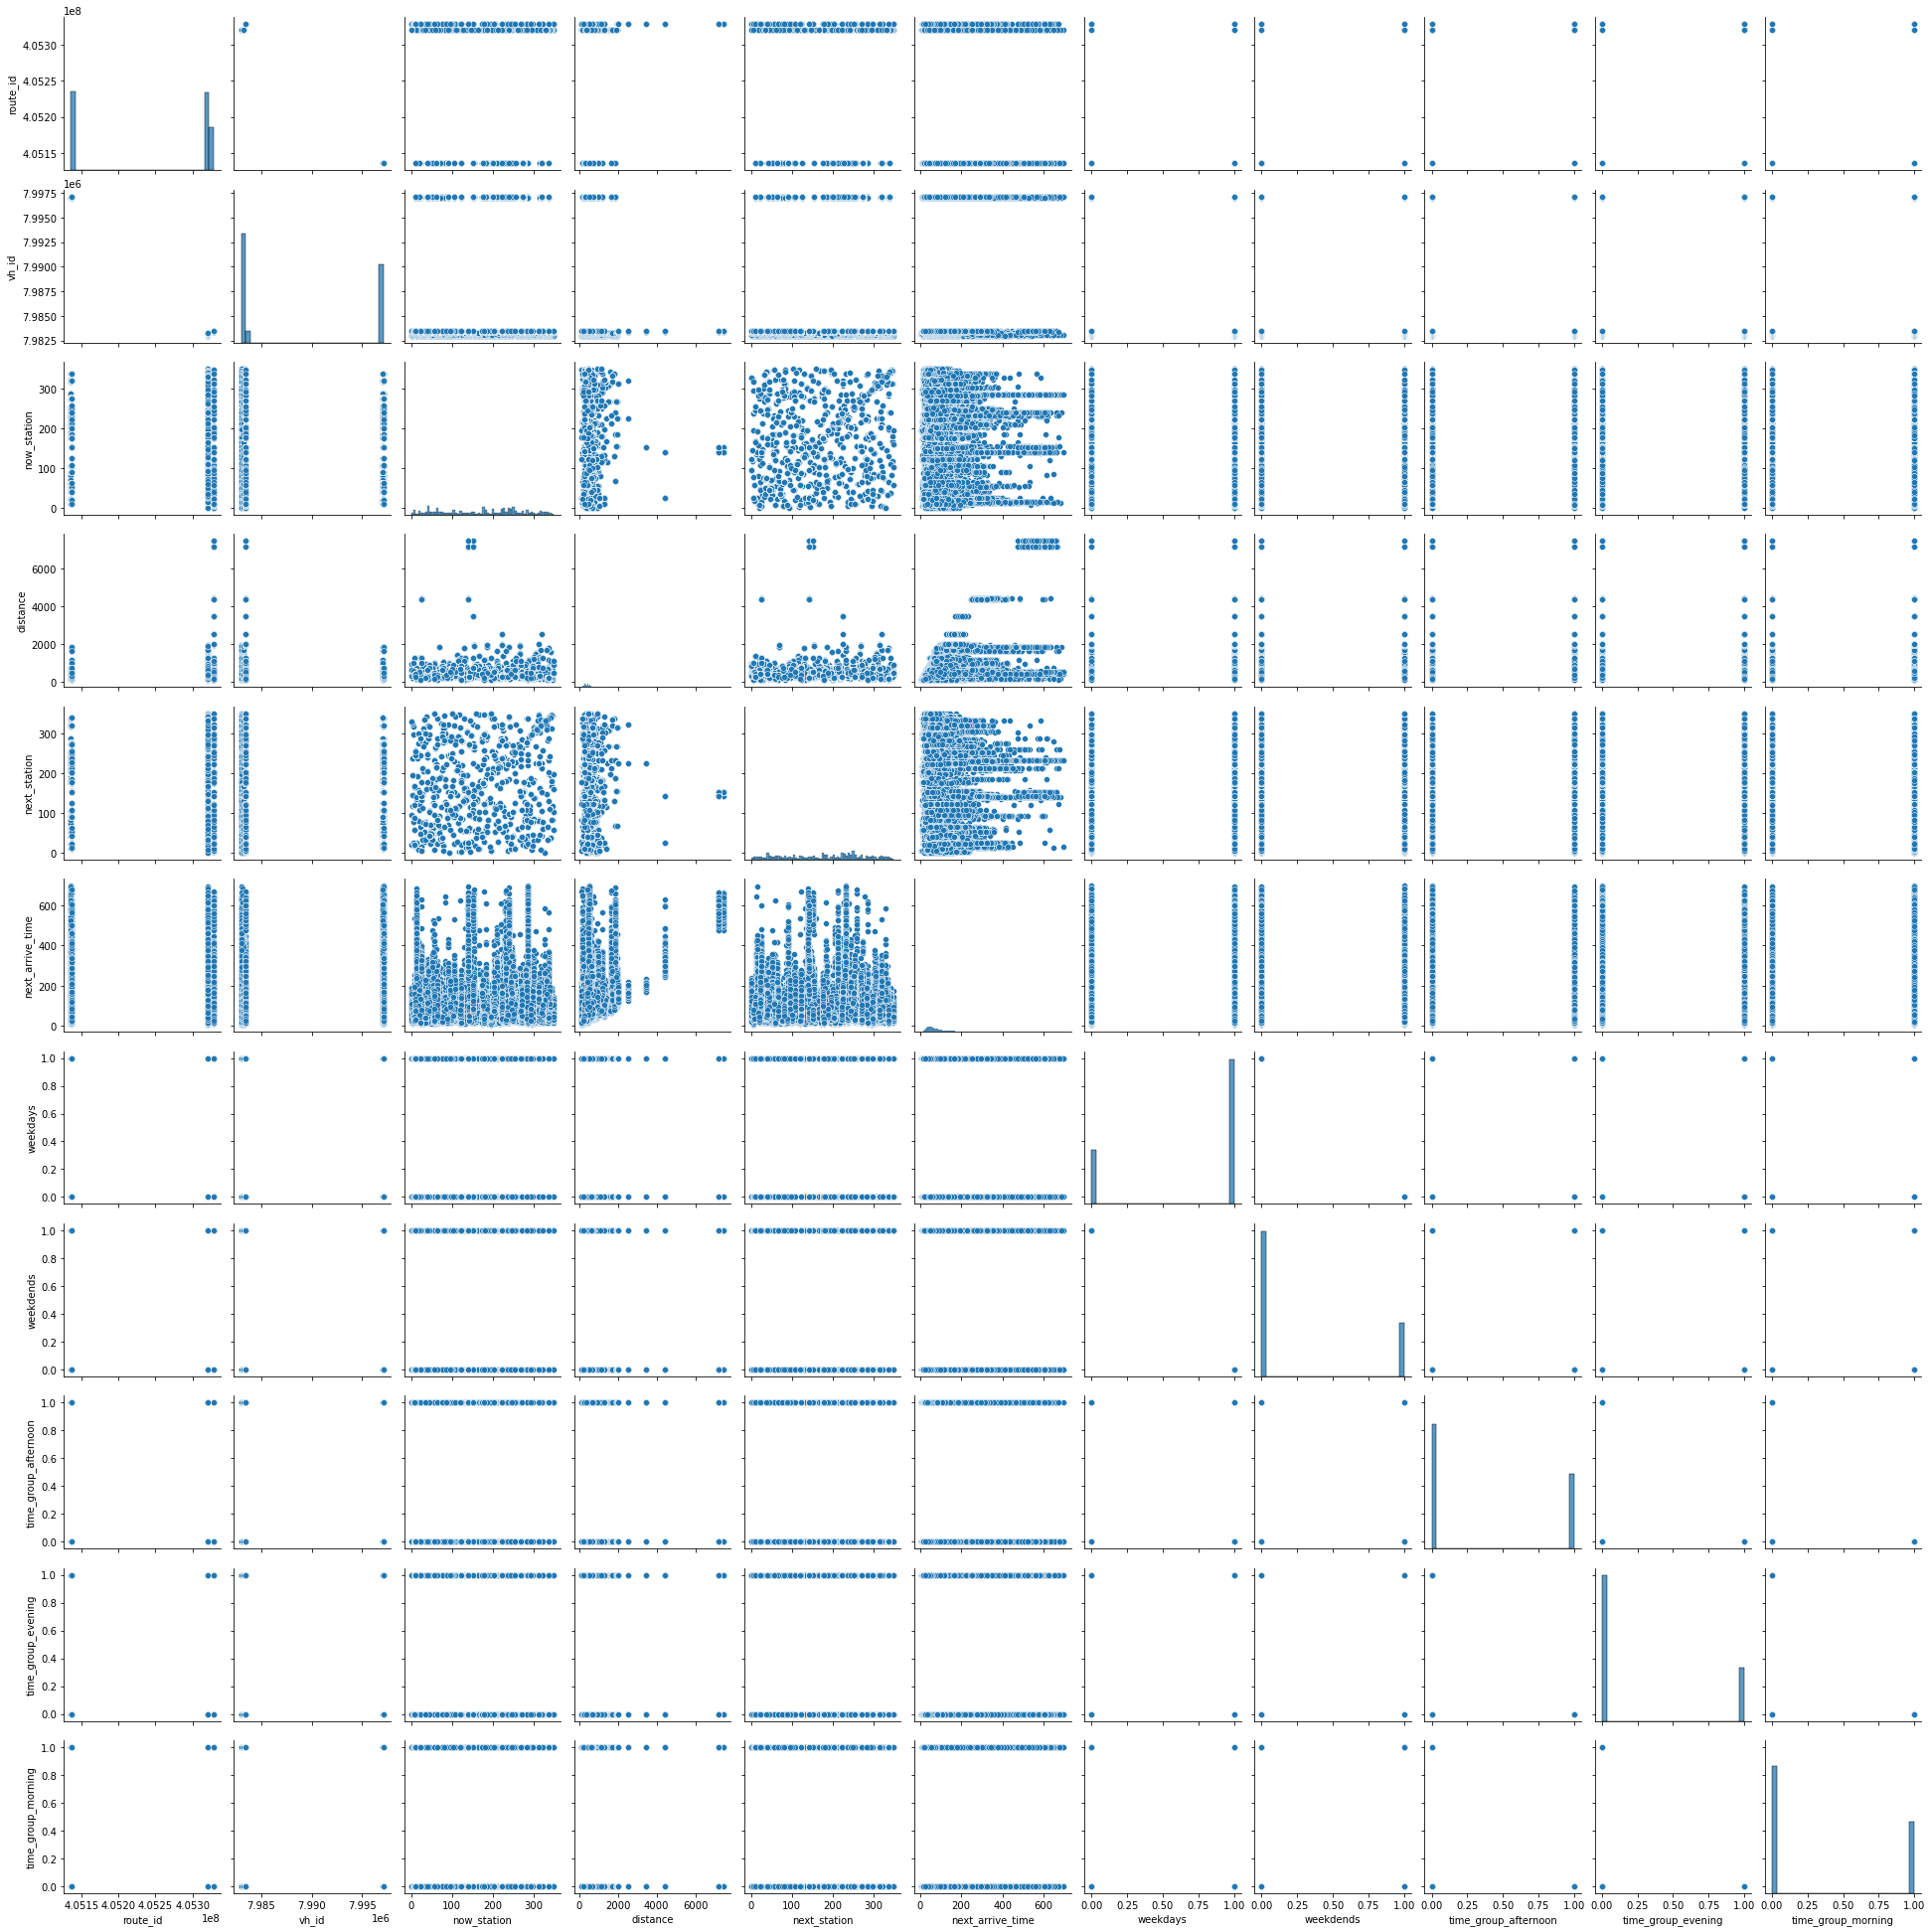

In [28]:
sns.pairplot(bus_tr) 

In [29]:
sns.pairplot(bus_tr, hue= 'route_id') # 10분이 넘게 걸리네..

C:\Users\CPB06GameN\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\CPB06GameN\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\CPB06GameN\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\CPB06GameN\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\CPB06GameN\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


In [ ]:
sns.set(style='whitegrid')
sns.pairplot(bus_tr, hue=)
#plt.title('Drink Pair Plot')
plt.show()

- XGBoost

In [ ]:
# https://bcho.tistory.com/1354
# https://heeya-stupidbutstudying.tistory.com/42?category=950711 # Good
# parameter https://asthtls.tistory.com/1275
# https://injo.tistory.com/44 good 
# https://rspring41.tistory.com/78
# https://nicola-ml.tistory.com/62 레이블인코딩 vs 원핫 명확정리!
# 왜 xgboost는 문자열 안될까? onlu 숫자형! 

In [ ]:
# 나는 ~이런 장점을 가진 xgboost 쓸건데, 쓰려면 

#### 2) 제출양식

In [ ]:
subm = pd.read_csv('submission_제출양식.csv', sep=',')
subm.head()

,id,next_arrive_time
0,210457,0
1,210458,0
2,210459,0
3,210460,0
4,210461,0


- ① id: 해당 데이터에서의 고유한 ID
- ② next_arrive_time: 다음 정류장에 도착할 때 까지 걸린 시간(단위 : 초)으로 답안 제출을 위해서 예측 해야 되는 값

#### 3) 데이터 통계량, 시각화 내용, 시사점

In [ ]:
pd.DataFrame(bus_tr, columns=['distance', 'next_arrive_time']).describe()

,distance,next_arrive_time
count,210457.000000,210457.000000
mean,490.256100,85.380824
std,520.563932,85.051170
min,97.000000,6.000000
25%,291.000000,44.000000
50%,384.000000,66.000000
75%,542.000000,102.000000
max,7461.000000,2996.000000


In [ ]:
times_ = bus_tr['now_arrive_time'] 
times_.hist(figsize=(12,6))
# 01시 ~ 04시의 데이터가 존재하지 않는다

KeyError: 'now_arrive_time'

In [ ]:
bus_tr['now_arrive_time'].unique()

array(['06시', '07시', '08시', '09시', '10시', '11시', '13시', '14시', '16시',
       '17시', '18시', '19시', '20시', '21시', '12시', '15시', '22시', '05시',
       '23시', '00시'], dtype=object)

<AxesSubplot:>

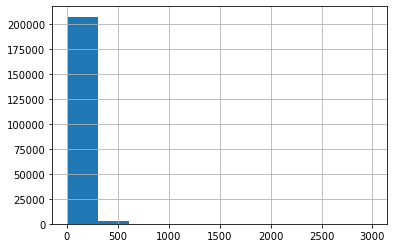

In [ ]:
target_ = bus_tr['next_arrive_time']
target_.hist()
#  다수의 데이터들이 0 ~ 200 정도의 분포를 띄고 있음

## 4. 참조할 코드의 이해

#### 1) 전처리

In [ ]:
bus_tr.shape, bus_te.shape

((210457, 9), (91774, 9))

- 이상치 제거

700 이라는 수치는 가장 최고의 distance의 next_arrive_time 이 600 대였기 때문에 그 이외 너무 큰 시간을 소비하는 구간은 측정 오류로 판단하였다

In [ ]:
bus_tr = bus_tr[bus_tr['next_arrive_time'] <= 700]
bus_tr.head()

,route_id,vh_id,now_station,now_arrive_time,distance,next_station,next_arrive_time,평일,주말
0,405136001,7997025,제주대학교입구,06시,266.0,제대마을,24,1,0
1,405136001,7997025,제대마을,06시,333.0,제대아파트,36,1,0
2,405136001,7997025,제대아파트,06시,415.0,제주대학교,40,1,0
3,405136001,7997025,남국원(아라방면),06시,578.0,제주여자중고등학교(아라방면),42,1,0
4,405136001,7997025,도호동,07시,374.0,은남동,64,1,0


- 정류장명 인코딩 작업

In [ ]:
station_encoder = LabelEncoder() # 인코더 생성

_station = list(bus_tr['now_station'].values) + list(bus_tr['next_station'].values) # bus_tr 의 모든 정류장 이름
station_set = set(_station)
print(len(station_set))
station_encoder.fit(list(station_set)) # 인코딩

# 모든 학습, 시험 데이터의 정류장 정보 치환
bus_tr['now_station'] = station_encoder.transform(bus_tr['now_station'])
bus_tr['next_station'] = station_encoder.transform(bus_tr['next_station'])
bus_te['now_station'] = station_encoder.transform(bus_te['now_station'])
bus_te['next_station'] = station_encoder.transform(bus_te['next_station'])
bus_tr.head()

351


,route_id,vh_id,now_station,now_arrive_time,distance,next_station,next_arrive_time,평일,주말
0,405136001,7997025,239,06시,266.0,227,24,1,0
1,405136001,7997025,227,06시,333.0,228,36,1,0
2,405136001,7997025,228,06시,415.0,235,40,1,0
3,405136001,7997025,41,06시,578.0,249,42,1,0
4,405136001,7997025,63,07시,374.0,221,64,1,0


#### 2) 자료분석

<AxesSubplot:>

C:\Users\CPB06GameN\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\CPB06GameN\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0, flags=flags)


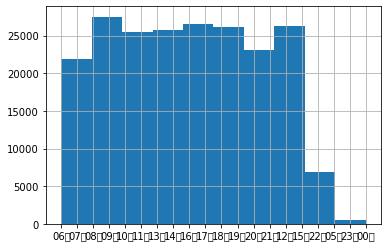

In [ ]:
times_ = bus_tr['now_arrive_time'] 
times_.hist()
# 01시 ~ 04시의 데이터가 존재하지 않는다

<AxesSubplot:>

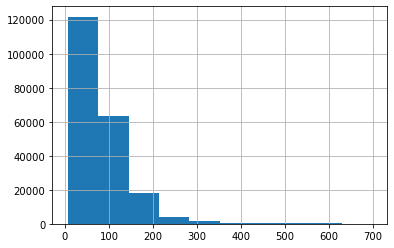

In [ ]:
target_ = bus_tr['next_arrive_time']
target_.hist()
#  다수의 데이터들이 0 ~ 200 정도의 분포를 띄고 있음

#### 3) 변수 선택 및 모델 구축

- 날짜 -> 요일 -> 평일/주말 변환

In [ ]:
bus_tr['date'] = pd.to_datetime(bus_tr['date']) # date 값을 datetime으로
bus_tr['weekday'] = bus_tr['date'].dt.weekday  # Monday 0, Sunday 6
bus_tr['weekday'] = bus_tr['weekday'].apply(lambda x: 0 if x < 5 else 1) 
# 0 ~ 5 는 월요일 ~ 금요일이므로 평일이면 0, 주말이면 1을 설정하였다

bus_tr = pd.get_dummies(bus_tr, columns=['weekday']) # 평일/주말에 대해 One-hot Encoding

bus_tr = bus_tr.drop('date', axis=1) # 필요없는 date 칼럼을 drop
bus_tr.head()

KeyError: 'date'

In [ ]:
bus_te['date'] = pd.to_datetime(bus_te['date'])
bus_te['weekday'] = bus_te['date'].dt.weekday  # Monday 0, Sunday 6
bus_te['weekday'] = bus_te['weekday'].apply(lambda x: 0 if x < 5 else 1)
bus_te = pd.get_dummies(bus_te, columns=['weekday'])

bus_te = bus_te.drop('date', axis=1)
bus_te.head()

,id,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,weekday_0,weekday_1
0,210457,405136001,7997025,360-1,33.457724,126.554014,227,07시,333.0,228,33.458783,126.557353,1,0
1,210458,405136001,7997025,360-1,33.458783,126.557353,228,07시,415.0,235,33.459893,126.561624,1,0
2,210459,405136001,7997025,360-1,33.478867,126.483833,323,08시,417.0,59,33.478850,126.488350,1,0
3,210460,405136001,7997025,360-1,33.478850,126.488350,59,08시,334.0,183,33.480700,126.489933,1,0
4,210461,405136001,7997025,360-1,33.480700,126.489933,183,08시,550.0,285,33.482077,126.485355,1,0


- 정류장 출발 시간 3분류 변환
- 기존 시간을 24개로 두게 되면 모델의 복잡도가 증가할 수 있으므로 과적합을 막기 위해 아침/오후/저녁 3가지 분류로 변환시킨다.

이후 이를 One-hot Encoding 시킨다.

In [ ]:
bus_tr['time_group']='group' #time_group 변수를 미리 생성

bus_tr.loc[(bus_tr['now_arrive_time']>='05시') & (bus_tr['now_arrive_time']<'12시') ,['time_group']]= 'morning' # 05~11시
bus_tr.loc[(bus_tr['now_arrive_time']>='12시') & (bus_tr['now_arrive_time']<'18시') ,['time_group']]= 'afternoon' #12~17시
bus_tr.loc[(bus_tr['now_arrive_time']>='18시') | (bus_tr['now_arrive_time']=='00시'),['time_group']]= 'evening' #18~00시

bus_tr = pd.get_dummies(bus_tr,columns=['time_group']) # 원 핫 인코딩을 수행
bus_tr = bus_tr.drop('now_arrive_time', axis=1) # 필요없는 now_arrive_time drop
bus_tr.head()

,id,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,distance,next_station,next_latitude,next_longitude,next_arrive_time,weekday_0,weekday_1,time_group_afternoon,time_group_evening,time_group_morning
0,0,405136001,7997025,360-1,33.456267,126.551750,239,266.0,227,33.457724,126.554014,24,1,0,0,0,1
1,1,405136001,7997025,360-1,33.457724,126.554014,227,333.0,228,33.458783,126.557353,36,1,0,0,0,1
2,2,405136001,7997025,360-1,33.458783,126.557353,228,415.0,235,33.459893,126.561624,40,1,0,0,0,1
3,3,405136001,7997025,360-1,33.479705,126.543811,41,578.0,249,33.484860,126.542928,42,1,0,0,0,1
4,4,405136001,7997025,360-1,33.485662,126.494923,63,374.0,221,33.485822,126.490897,64,1,0,0,0,1


In [ ]:
bus_te['time_group']='group' #time_group 변수를 미리 생성

bus_te.loc[(bus_te['now_arrive_time']>='05시') & (bus_te['now_arrive_time']<'12시') ,['time_group']]= 'morning' # 05~11시
bus_te.loc[(bus_te['now_arrive_time']>='12시') & (bus_te['now_arrive_time']<'18시') ,['time_group']]= 'afternoon' #12~17시
bus_te.loc[(bus_te['now_arrive_time']>='18시') | (bus_te['now_arrive_time']=='00시'),['time_group']]= 'evening' #18~00시

bus_te = pd.get_dummies(bus_te,columns=['time_group']) # 원 핫 인코딩을 수행
bus_te = bus_te.drop('now_arrive_time', axis=1) # 필요없는 now_arrive_time drop
bus_te.head()

,id,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,distance,next_station,next_latitude,next_longitude,weekday_0,weekday_1,time_group_afternoon,time_group_evening,time_group_morning
0,210457,405136001,7997025,360-1,33.457724,126.554014,227,333.0,228,33.458783,126.557353,1,0,0,0,1
1,210458,405136001,7997025,360-1,33.458783,126.557353,228,415.0,235,33.459893,126.561624,1,0,0,0,1
2,210459,405136001,7997025,360-1,33.478867,126.483833,323,417.0,59,33.478850,126.488350,1,0,0,0,1
3,210460,405136001,7997025,360-1,33.478850,126.488350,59,334.0,183,33.480700,126.489933,1,0,0,0,1
4,210461,405136001,7997025,360-1,33.480700,126.489933,183,550.0,285,33.482077,126.485355,1,0,0,0,1


- 필요없는 관측치 제거

In [ ]:
bus_tr = bus_tr.drop(['id', 'route_nm', 'next_latitude', 'next_longitude', 
                              'now_latitude', 'now_longitude'], axis=1)
bus_tr.head()

,route_id,vh_id,now_station,distance,next_station,next_arrive_time,weekday_0,weekday_1,time_group_afternoon,time_group_evening,time_group_morning
0,405136001,7997025,239,266.0,227,24,1,0,0,0,1
1,405136001,7997025,227,333.0,228,36,1,0,0,0,1
2,405136001,7997025,228,415.0,235,40,1,0,0,0,1
3,405136001,7997025,41,578.0,249,42,1,0,0,0,1
4,405136001,7997025,63,374.0,221,64,1,0,0,0,1


In [ ]:
bus_te = bus_te.drop(['route_nm', 'next_latitude', 'next_longitude', 
                              'now_latitude', 'now_longitude'], axis=1)
bus_te.head()

,id,route_id,vh_id,now_station,distance,next_station,weekday_0,weekday_1,time_group_afternoon,time_group_evening,time_group_morning
0,210457,405136001,7997025,227,333.0,228,1,0,0,0,1
1,210458,405136001,7997025,228,415.0,235,1,0,0,0,1
2,210459,405136001,7997025,323,417.0,59,1,0,0,0,1
3,210460,405136001,7997025,59,334.0,183,1,0,0,0,1
4,210461,405136001,7997025,183,550.0,285,1,0,0,0,1


- 학습 데이터 구성

In [ ]:
# 학습 데이터 칼럼에서 목표치인 next_arrive_time만 제거하여 선택한다.
input_var = list(bus_tr.columns) 
input_var.remove('next_arrive_time')

Xtrain = bus_tr[input_var] # 학습 데이터 선택
Ytrain = bus_tr['next_arrive_time'] # target 값인 Y 데이터 선택

Xtest = bus_te[input_var] # 시험 데이터도 선택

- 모델 구축 및 학습 준비

빠른 학습과 정밀도를 보장하는 eXtreme Gradient Boosting 을 사용한다.

K-Fold를 이용하여 K-Validation을 수행한다.

(random seed는 Regressor 110, KFold 777 고정)

In [ ]:
model = XGBRegressor(random_state=110, verbosity=0, nthread=23, n_estimators=980, max_depth=4)
kfold = KFold(n_splits=8, shuffle=True, random_state=777)
n_iter = 0
cv_score = []

def rmse(target, pred):
    return np.sqrt(np.sum(np.power(target - pred, 2)) / np.size(pred))

#### 4) 모델 학습 및 검증

In [ ]:
for train_index, test_index in kfold.split(Xtrain, Ytrain):
    # K Fold가 적용된 train, test 데이터를 불러온다
    X_train, X_test = Xtrain.iloc[train_index,:], Xtrain.iloc[test_index, :]
    Y_train, Y_test = Ytrain.iloc[train_index], Ytrain.iloc[test_index]
    
    # 모델 학습과 예측 수행
    model.fit(X_train, Y_train)
    pred = model.predict(X_test)
    print(pred)
    
    # 정확도 RMSE 계산
    n_iter += 1
    score = rmse(Y_test, pred)
    print(score)
    cv_score.append(score)
print('\n교차 검증별 RMSE :', np.round(cv_score, 4))
print('평균 검증 RMSE :', np.mean(cv_score))

[119.30418   54.8084    59.053844 ...  36.704453 554.14197   30.391424]
31.32513123867448
[53.276646 58.400414 93.77479  ... 83.12635  64.52432  17.882067]
32.32571608664957
[149.99481 117.55994  99.61706 ... 102.28884 121.88896 236.62187]
32.03947325583079
[66.98095  72.96737  89.81083  ... 26.591532 64.817474 77.883446]
31.870870687124526
[36.56551  67.78904  64.33988  ... 71.445496 98.97535  26.077995]
32.19741951870947
[ 51.15618  139.43466  128.37589  ...  84.20797   74.97951   35.578228]
32.17423561625797
[ 30.90595  130.89384  100.43777  ...  84.67226  104.516754  66.13938 ]
31.507528933147444
[184.62093   37.218834  50.652264 ...  34.079563  72.79278  128.55641 ]
31.93955336703729

교차 검증별 RMSE : [31.3251 32.3257 32.0395 31.8709 32.1974 32.1742 31.5075 31.9396]
평균 검증 RMSE : 31.92249108792894


#### 6) 보완점:
- 각종 하이퍼파라미터를 테스트 해본 결과이다. GridSearch를 사용하려 했으나 자세한 사용법을 몰라 임시로 하이퍼파라미터를 탐색하였다.